In [86]:
import pandas as pd
import tqdm
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
pd.options.mode.chained_assignment = None  # default='warn'

In [110]:
!pip install ipython-autotime

In [ ]:
CB91_Blue = '#2CBDFE'
CB91_Green = '#47DBCD'
CB91_Pink = '#F3A0F2'
CB91_Purple = '#9D2EC5'
CB91_Violet = '#661D98'
CB91_Amber = '#F5B14C'
color_list = [CB91_Blue, CB91_Pink, CB91_Green, CB91_Amber,
              CB91_Purple, CB91_Violet]
params = {"ytick.color" : "w",
          "xtick.color" : "w",
          'axes.labelsize' : 15,
          "axes.labelcolor" : "w",
          "axes.edgecolor" : "w",
          "axes.titlecolor": "w", 
          'figure.figsize': [20, 8], 
          'axes.prop_cycle': plt.cycler(color=color_list), 
          'figure.dpi' : 75, 
          'legend.fontsize': 10,
          'font.size': 15 
          }
plt.rcParams.update(params)

In [1]:
!gdown "https://drive.google.com/uc?id=1nTpNYwwCKmhy5x0bGb17gDR4Sbi48ete"

Downloading...
From: https://drive.google.com/uc?id=1nTpNYwwCKmhy5x0bGb17gDR4Sbi48ete
To: /content/featured_dataset_final_2013_2019.csv
100% 1.46M/1.46M [00:00<00:00, 92.3MB/s]


In [87]:
df_2 = pd.read_csv('featured_dataset_final_2013_2019.csv', index_col = 0)
df_2['DATE'] = pd.to_datetime(df_2['DATE'])
df_2.set_index('DATE', inplace=True)
df_2.head()

,UNIQUE_CARRIER_NAME,194,26,339,35,359,406,416,461,482,530,608,612,614,616,617,619,622,623,624,625,626,627,629,631,634,637,638,644,650,654,655,656,673,674,675,676,677,678,687,...,Price,TOP1_DEST,TOP1_PRCP,TOP1_SNOW,TOP1_TAVG,TOP1_TMAX,TOP1_TSUN,TOP1_WSPD,TOP2_DEST,TOP2_PRCP,TOP2_SNOW,TOP2_TAVG,TOP2_TMAX,TOP2_TSUN,TOP2_WSPD,TOP3_DEST,TOP3_PRCP,TOP3_SNOW,TOP3_TAVG,TOP3_TMAX,TOP3_TSUN,TOP3_WSPD,TOP4_DEST,TOP4_PRCP,TOP4_SNOW,TOP4_TAVG,TOP4_TMAX,TOP4_TSUN,TOP4_WSPD,TOP5_DEST,TOP5_PRCP,TOP5_SNOW,TOP5_TAVG,TOP5_TMAX,TOP5_TSUN,TOP5_WSPD,TOP_1_DEST_FQ,UNEMPLOYMENT,LOAD_FACTOR,LOAD_FACTOR_SHIFTED
DATE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-01-01,Air Wisconsin Airlines Corp,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,1.0,0.0,0.000,0.0,0.0,0.0,0.00,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.000,...,97.41,"Charlotte, NC",150.7,0.0,24.723333,34.4,0.0,10.083333,"Philadelphia, PA",83.1,6.428571,2.657143,19.4,0.0,15.271429,"Washington, DC",126.3,0.000000,21.138710,33.9,0.0,13.696774,"Boston, MA",100.0,0.000000,20.596667,35.6,0.0,14.920000,"Scranton/Wilkes-Barre, PA",68.3,0.000000,9.263333,25.6,0.0,12.000000,0.155556,7.8%,0.694164,0.649511
2013-01-01,Alaska Airlines Inc.,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.167,0.356,0.0,0.333,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.144,0.0,0.0,0.0,0.00,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.000,...,97.41,"Seattle, WA",154.6,0.0,6.664516,15.0,0.0,15.012903,"Anchorage, AK",20.9,465.483871,-2.345161,5.6,0.0,8.900000,"Portland, OR",387.2,0.000000,6.174194,17.2,0.0,17.035484,"Juneau, AK",256.4,0.000000,7.148387,13.3,0.0,12.970968,"Palm Springs, CA",0.0,0.000000,22.246667,38.7,0.0,8.663333,0.247748,7.8%,0.829975,0.833743
2013-01-01,Allegiant Air,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.000,0.0,0.048,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.00,0.012,0.940,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.000,...,97.41,"Las Vegas, NV",0.0,0.0,18.003226,30.6,0.0,12.561290,"Sanford, FL",22.6,0.000000,18.467742,30.0,0.0,12.616129,"Phoenix, AZ",7.8,0.000000,13.846429,26.7,0.0,8.528571,"Wendover, UT",26.9,0.000000,3.453333,16.7,0.0,9.610000,"St. Petersburg, FL",200.8,0.000000,27.400000,35.0,0.0,9.513333,0.097510,7.8%,0.868898,0.892041
2013-01-01,American Airlines Inc.,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.335,0.0,0.000,0.0,0.173,0.000,0.000,0.041,0.059,0.027,0.0,0.0,0.000,0.0,0.0,0.0,0.00,0.000,0.364,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.000,...,97.41,"Dallas/Fort Worth, TX",88.6,0.0,10.266667,28.3,0.0,16.222581,"Chicago, IL",45.3,0.000000,13.587097,26.7,0.0,18.080645,"Miami, FL",157.2,0.000000,27.890000,33.3,14733.0,12.210000,"Los Angeles, CA",31.7,0.000000,15.132258,28.3,0.0,7.029032,"New York, NY",128.8,21.935484,4.290323,22.8,0.0,20.238710,0.198728,7.8%,0.801683,0.783544
2013-01-01,Delta Air Lines Inc.,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.026,0.120,0.0,0.000,0.0,0.115,0.025,0.005,0.000,0.035,0.005,0.0,0.0,0.000,0.0,0.0,0.0,0.04,0.000,0.141,0.073,0.0,0.0,0.0,0.0,0.0,0.0,0.016,...,97.41,"Atlanta, GA",149.7,0.0,17.023333,28.9,0.0,14.503333,"Minneapolis, MN",56.3,66.333333,3.196667,28.9,0.0,15.380000,"Detroit, MI",37.8,71.612903,-2.496774,14.4,0.0,15.729032,"Salt Lake City, UT",27.1,41.071429,4.014286,16.7,0.0,13.575000,"New York, NY",128.8,21.935484,4.290323,22.8,0.0,20.238710,0.183770,7.8%,0.804674,0.794658


In [89]:
carriers = np.unique(df_2['UNIQUE_CARRIER_NAME'])
dataframe_collection = {} 
for carrier in carriers:
  if carrier != 'US Airways Inc.':
    dataframe_collection[carrier] = df_2[df_2['UNIQUE_CARRIER_NAME'] == carrier]
dataframe_collection['SkyWest Airlines Inc.'].head()

,UNIQUE_CARRIER_NAME,194,26,339,35,359,406,416,461,482,530,608,612,614,616,617,619,622,623,624,625,626,627,629,631,634,637,638,644,650,654,655,656,673,674,675,676,677,678,687,...,Price,TOP1_DEST,TOP1_PRCP,TOP1_SNOW,TOP1_TAVG,TOP1_TMAX,TOP1_TSUN,TOP1_WSPD,TOP2_DEST,TOP2_PRCP,TOP2_SNOW,TOP2_TAVG,TOP2_TMAX,TOP2_TSUN,TOP2_WSPD,TOP3_DEST,TOP3_PRCP,TOP3_SNOW,TOP3_TAVG,TOP3_TMAX,TOP3_TSUN,TOP3_WSPD,TOP4_DEST,TOP4_PRCP,TOP4_SNOW,TOP4_TAVG,TOP4_TMAX,TOP4_TSUN,TOP4_WSPD,TOP5_DEST,TOP5_PRCP,TOP5_SNOW,TOP5_TAVG,TOP5_TMAX,TOP5_TSUN,TOP5_WSPD,TOP_1_DEST_FQ,UNEMPLOYMENT,LOAD_FACTOR,LOAD_FACTOR_SHIFTED
DATE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-01-01,SkyWest Airlines Inc.,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.087,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.437,0.351,0.0,0.0,0.125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,97.41,"Salt Lake City, UT",27.1,41.071429,4.014286,16.7,0.0,13.575000,"Denver, CO",0.0,0.0,29.250000,34.9,0.0,0.0,"Chicago, IL",45.3,0.000000,13.587097,26.7,0.0,18.080645,"Minneapolis, MN",56.3,66.333333,3.196667,28.9,0.0,15.380000,"Los Angeles, CA",31.7,0.0,15.132258,28.3,0.0,7.029032,0.095722,7.8%,0.784116,0.754731
2013-02-01,SkyWest Airlines Inc.,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.080,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.444,0.356,0.0,0.0,0.120,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,91.83,"Salt Lake City, UT",65.8,18.709677,7.761290,22.8,0.0,13.658065,"Denver, CO",70.8,0.0,28.244444,34.2,0.0,0.0,"Chicago, IL",123.9,13.533333,8.486667,23.3,0.0,18.226667,"Los Angeles, CA",6.9,0.000000,15.767857,28.9,0.0,9.771429,"Minneapolis, MN",76.1,0.0,19.938710,37.8,0.0,13.245161,0.091533,7.9%,0.805831,0.769647
2013-03-01,SkyWest Airlines Inc.,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.096,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.467,0.320,0.0,0.0,0.117,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,97.23,"Salt Lake City, UT",48.6,0.000000,13.060000,30.6,0.0,14.360000,"Denver, CO",234.4,0.0,27.764516,34.4,0.0,0.0,"Los Angeles, CA",12.5,0.000000,17.600000,32.2,0.0,10.080645,"San Francisco, CA",186.6,0.000000,12.664286,18.3,0.0,15.150000,"Minneapolis, MN",96.1,0.0,22.786667,37.2,0.0,15.270000,0.103614,7.7%,0.826178,0.807820
2013-04-01,SkyWest Airlines Inc.,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.078,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.447,0.360,0.0,0.0,0.115,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,93.13,"Salt Lake City, UT",32.1,0.000000,17.845161,32.2,0.0,12.687097,"Denver, CO",643.8,0.0,27.740000,33.1,0.0,0.0,"Chicago, IL",25.3,19.580645,-2.600000,9.4,0.0,17.019355,"San Francisco, CA",68.4,0.000000,14.053333,25.6,0.0,13.648387,"Houston, TX",9.7,0.0,29.283871,36.7,0.0,13.341935,0.094044,7.6%,0.818458,0.824841
2013-05-01,SkyWest Airlines Inc.,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.081,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.448,0.343,0.0,0.0,0.129,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,91.61,"Salt Lake City, UT",1.3,0.000000,24.236667,36.1,0.0,15.500000,"Denver, CO",688.8,0.0,26.500000,30.2,0.0,0.0,"Chicago, IL",33.5,8.724138,0.255172,18.3,0.0,18.686207,"Houston, TX",180.5,0.000000,29.690323,37.8,0.0,10.487097,"Minneapolis, MN",71.9,0.0,23.264516,33.3,0.0,11.838710,0.098131,7.5%,0.836107,0.840859


In [ ]:
def label_encoding(data):
  le = LabelEncoder()
  for column_name in data.columns:
      if data[column_name].dtype == object:
          data[column_name] = le.fit_transform(data[column_name])
      else:
          pass
  return data

In [104]:
win_length = 10
batch_size = 2
num_features = 104

In [105]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(128, input_shape= (win_length, num_features), return_sequences=True))
model.add(tf.keras.layers.LeakyReLU(alpha=0.5))
model.add(tf.keras.layers.LSTM(128, return_sequences=True))
model.add(tf.keras.layers.LeakyReLU(alpha=0.5))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.LSTM(64, return_sequences=False))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(1))

model.compile(loss=tf.losses.MeanSquaredError(), optimizer=tf.optimizers.Adam(), metrics=[tf.metrics.MeanAbsoluteError()])

In [106]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_27 (LSTM)               (None, 10, 128)           119296    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 10, 128)           0         
_________________________________________________________________
lstm_28 (LSTM)               (None, 10, 128)           131584    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 10, 128)           0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 10, 128)           0         
_________________________________________________________________
lstm_29 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)               

In [107]:
model2 = tf.keras.Sequential()
model2.add(tf.keras.layers.LSTM(64, return_sequences=True, input_shape=(win_length, num_features)))
model2.add(tf.keras.layers.LSTM(128, return_sequences=True))
model2.add(tf.keras.layers.LSTM(256, return_sequences=True))
model2.add(tf.keras.layers.LSTM(128, return_sequences=True))
model2.add(tf.keras.layers.LSTM(64, return_sequences=True))
model2.add(tf.keras.layers.LSTM(num_features, return_sequences=False)) 
model2.add(tf.keras.layers.Dense(1))

model2.compile(loss=tf.losses.MeanAbsoluteError(), optimizer=tf.optimizers.Adam(), metrics=[tf.metrics.MeanAbsoluteError()])

In [108]:
model2.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_30 (LSTM)               (None, 10, 64)            43264     
_________________________________________________________________
lstm_31 (LSTM)               (None, 10, 128)           98816     
_________________________________________________________________
lstm_32 (LSTM)               (None, 10, 256)           394240    
_________________________________________________________________
lstm_33 (LSTM)               (None, 10, 128)           197120    
_________________________________________________________________
lstm_34 (LSTM)               (None, 10, 64)            49408     
_________________________________________________________________
lstm_35 (LSTM)               (None, 104)               70304     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

In [114]:
def LSTM_forecast(dataframe_collection, win_length, batch_size, num_features, model_LSTM):
  predictions = {}
  for dataframe in dataframe_collection:
    print('Predicting the carrier ' + dataframe + '....')
    df = dataframe_collection[dataframe].copy()
    df = label_encoding(df)
    df.pop('UNIQUE_CARRIER_NAME')
    df.pop('LOAD_FACTOR_SHIFTED')
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(df)
    features = data_scaled
    target = data_scaled[:, -1]
    x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state = 12, shuffle = False)
    train_generator = TimeseriesGenerator(x_train, y_train, length=win_length, sampling_rate=1, batch_size=batch_size)
    test_generator = TimeseriesGenerator(x_test, y_test, length=win_length, sampling_rate=1, batch_size=batch_size)
    model_LSTM.fit(train_generator, epochs = 50 , validation_data=test_generator, shuffle=False, verbose = 0)
    predictions_tmp = model_LSTM.predict(test_generator)
    df_pred = pd.concat([pd.DataFrame(x_test[:,:-1][win_length:]), pd.DataFrame(predictions_tmp)], axis=1)
    df_pred.columns = range(len(df_pred.columns))
    rev_trans = scaler.inverse_transform(df_pred)
    df_final = df[predictions_tmp.shape[0]*-1:]
    df_final['PRED'] = rev_trans[:, -1]
    tmp = df_final[['LOAD_FACTOR', 'PRED']]
    predictions[dataframe] = tmp
    print('METRIC TEMPORAIRE :' + str(mean_absolute_error(df_final['PRED'], df_final['LOAD_FACTOR'])))
    plt.plot(df_final.index, df_final['LOAD_FACTOR'], label='True Load Factor')
    plt.plot(df_final.index, df_final['PRED'], label='Predicted Load Factor')
    plt.title('Predictions for the carrier : ' + dataframe)
    plt.show()
    print(predictions)
  return predictions

Predicting the carrier Air Wisconsin Airlines Corp....


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


METRIC TEMPORAIRE :0.028888648251936287


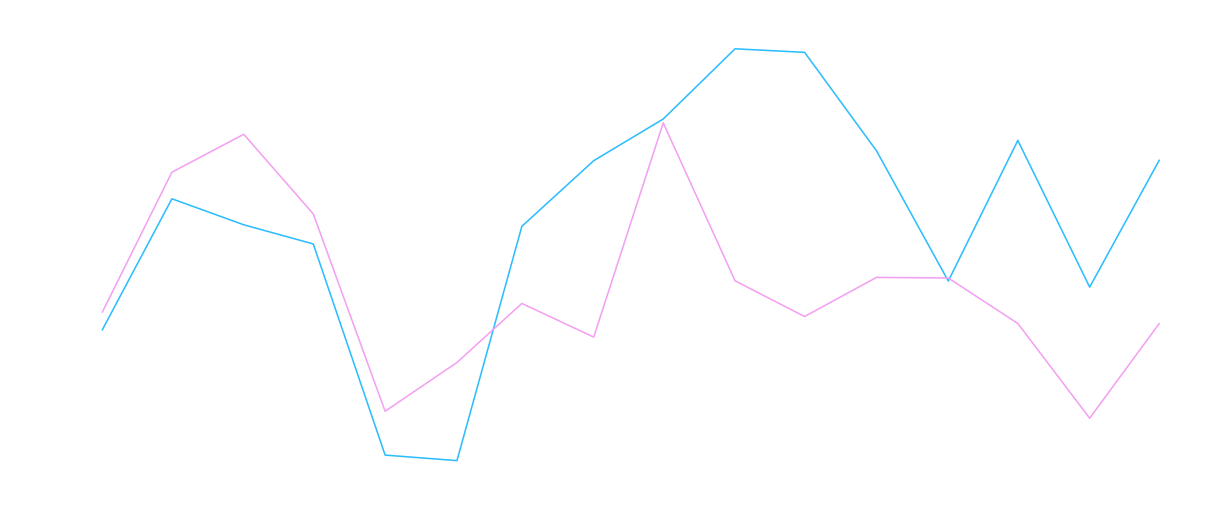

{'Air Wisconsin Airlines Corp':             LOAD_FACTOR      PRED
DATE                             
2018-09-01     0.769966  0.774876
2018-10-01     0.806268  0.813643
2018-11-01     0.799055  0.824140
2018-12-01     0.793741  0.802061
2019-01-01     0.735209  0.747367
2019-02-01     0.733679  0.760886
2019-03-01     0.798623  0.777255
2019-04-01     0.816824  0.767923
2019-05-01     0.828379  0.827312
2019-06-01     0.847843  0.783519
2019-07-01     0.846853  0.773625
2019-08-01     0.819580  0.784470
2019-09-01     0.783461  0.784295
2019-10-01     0.822442  0.771708
2019-11-01     0.781773  0.745434
2019-12-01     0.816928  0.771671}
Predicting the carrier Alaska Airlines Inc.....


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


METRIC TEMPORAIRE :0.021338009947866624


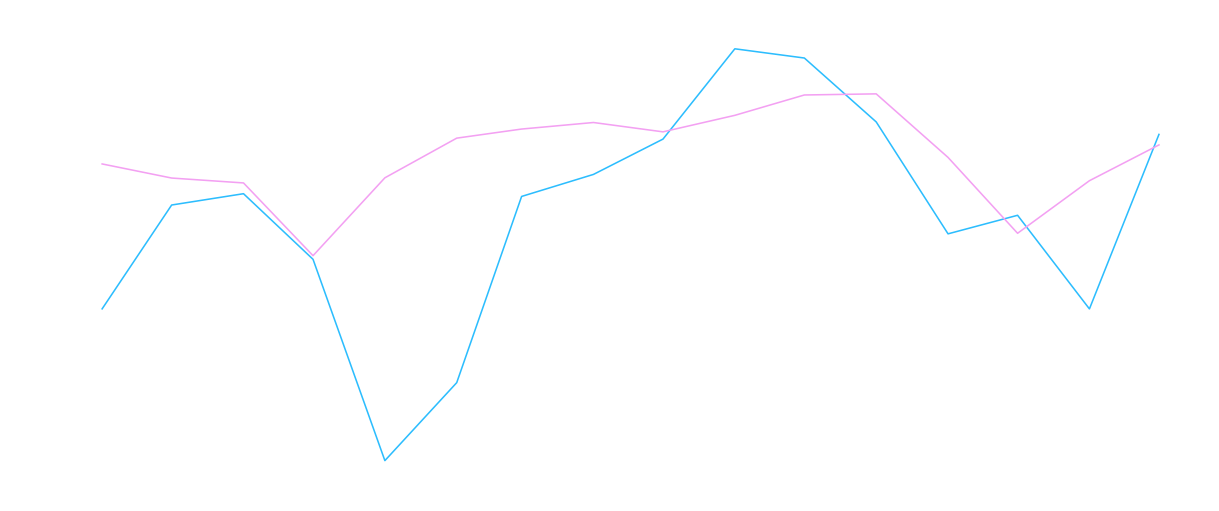

{'Air Wisconsin Airlines Corp':             LOAD_FACTOR      PRED
DATE                             
2018-09-01     0.769966  0.774876
2018-10-01     0.806268  0.813643
2018-11-01     0.799055  0.824140
2018-12-01     0.793741  0.802061
2019-01-01     0.735209  0.747367
2019-02-01     0.733679  0.760886
2019-03-01     0.798623  0.777255
2019-04-01     0.816824  0.767923
2019-05-01     0.828379  0.827312
2019-06-01     0.847843  0.783519
2019-07-01     0.846853  0.773625
2019-08-01     0.819580  0.784470
2019-09-01     0.783461  0.784295
2019-10-01     0.822442  0.771708
2019-11-01     0.781773  0.745434
2019-12-01     0.816928  0.771671, 'Alaska Airlines Inc.':             LOAD_FACTOR      PRED
DATE                             
2018-09-01     0.811888  0.852953
2018-10-01     0.841316  0.848957
2018-11-01     0.844520  0.847571
2018-12-01     0.825926  0.826961
2019-01-01     0.768883  0.849023
2019-02-01     0.790976  0.860266
2019-03-01     0.843745  0.862841
2019-04-01     0.849986  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


METRIC TEMPORAIRE :0.018872770815876218


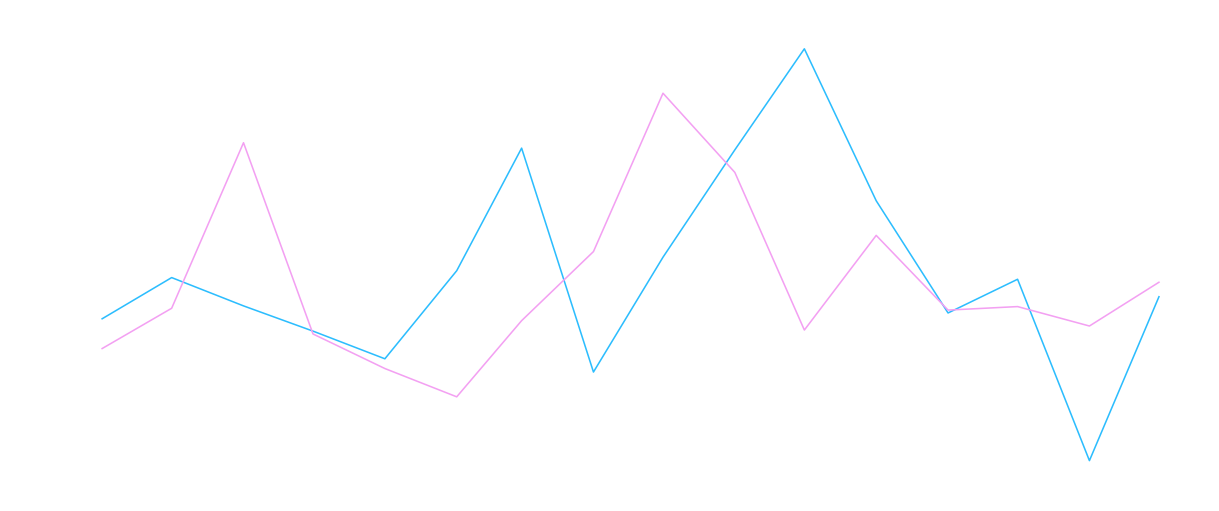

{'Air Wisconsin Airlines Corp':             LOAD_FACTOR      PRED
DATE                             
2018-09-01     0.769966  0.774876
2018-10-01     0.806268  0.813643
2018-11-01     0.799055  0.824140
2018-12-01     0.793741  0.802061
2019-01-01     0.735209  0.747367
2019-02-01     0.733679  0.760886
2019-03-01     0.798623  0.777255
2019-04-01     0.816824  0.767923
2019-05-01     0.828379  0.827312
2019-06-01     0.847843  0.783519
2019-07-01     0.846853  0.773625
2019-08-01     0.819580  0.784470
2019-09-01     0.783461  0.784295
2019-10-01     0.822442  0.771708
2019-11-01     0.781773  0.745434
2019-12-01     0.816928  0.771671, 'Alaska Airlines Inc.':             LOAD_FACTOR      PRED
DATE                             
2018-09-01     0.811888  0.852953
2018-10-01     0.841316  0.848957
2018-11-01     0.844520  0.847571
2018-12-01     0.825926  0.826961
2019-01-01     0.768883  0.849023
2019-02-01     0.790976  0.860266
2019-03-01     0.843745  0.862841
2019-04-01     0.849986  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


METRIC TEMPORAIRE :0.024950435029292874


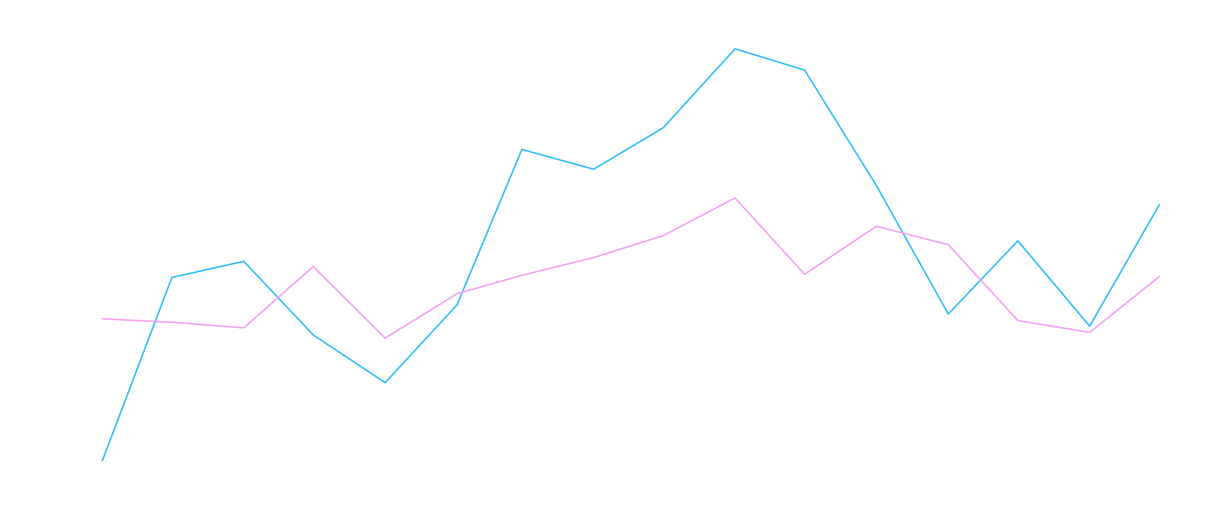

{'Air Wisconsin Airlines Corp':             LOAD_FACTOR      PRED
DATE                             
2018-09-01     0.769966  0.774876
2018-10-01     0.806268  0.813643
2018-11-01     0.799055  0.824140
2018-12-01     0.793741  0.802061
2019-01-01     0.735209  0.747367
2019-02-01     0.733679  0.760886
2019-03-01     0.798623  0.777255
2019-04-01     0.816824  0.767923
2019-05-01     0.828379  0.827312
2019-06-01     0.847843  0.783519
2019-07-01     0.846853  0.773625
2019-08-01     0.819580  0.784470
2019-09-01     0.783461  0.784295
2019-10-01     0.822442  0.771708
2019-11-01     0.781773  0.745434
2019-12-01     0.816928  0.771671, 'Alaska Airlines Inc.':             LOAD_FACTOR      PRED
DATE                             
2018-09-01     0.811888  0.852953
2018-10-01     0.841316  0.848957
2018-11-01     0.844520  0.847571
2018-12-01     0.825926  0.826961
2019-01-01     0.768883  0.849023
2019-02-01     0.790976  0.860266
2019-03-01     0.843745  0.862841
2019-04-01     0.849986  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


METRIC TEMPORAIRE :0.025906813603405354


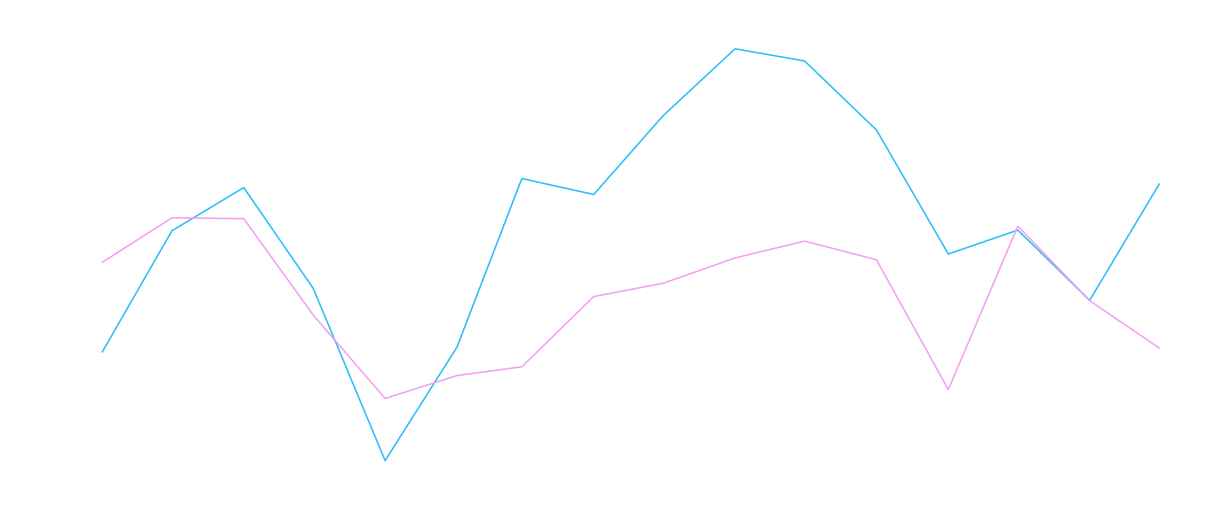

{'Air Wisconsin Airlines Corp':             LOAD_FACTOR      PRED
DATE                             
2018-09-01     0.769966  0.774876
2018-10-01     0.806268  0.813643
2018-11-01     0.799055  0.824140
2018-12-01     0.793741  0.802061
2019-01-01     0.735209  0.747367
2019-02-01     0.733679  0.760886
2019-03-01     0.798623  0.777255
2019-04-01     0.816824  0.767923
2019-05-01     0.828379  0.827312
2019-06-01     0.847843  0.783519
2019-07-01     0.846853  0.773625
2019-08-01     0.819580  0.784470
2019-09-01     0.783461  0.784295
2019-10-01     0.822442  0.771708
2019-11-01     0.781773  0.745434
2019-12-01     0.816928  0.771671, 'Alaska Airlines Inc.':             LOAD_FACTOR      PRED
DATE                             
2018-09-01     0.811888  0.852953
2018-10-01     0.841316  0.848957
2018-11-01     0.844520  0.847571
2018-12-01     0.825926  0.826961
2019-01-01     0.768883  0.849023
2019-02-01     0.790976  0.860266
2019-03-01     0.843745  0.862841
2019-04-01     0.849986  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


METRIC TEMPORAIRE :0.039094315306494105


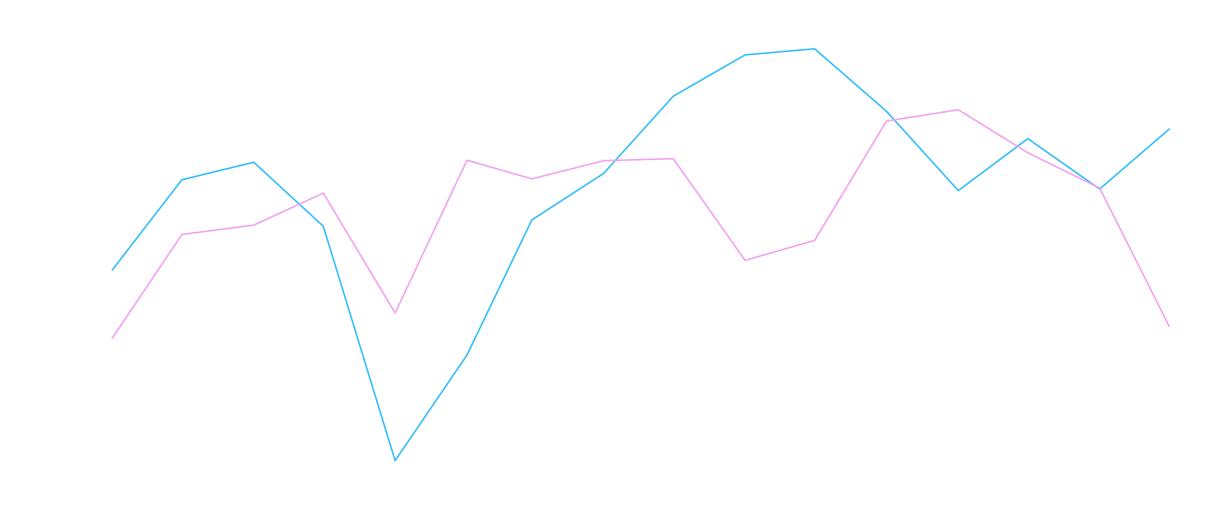

{'Air Wisconsin Airlines Corp':             LOAD_FACTOR      PRED
DATE                             
2018-09-01     0.769966  0.774876
2018-10-01     0.806268  0.813643
2018-11-01     0.799055  0.824140
2018-12-01     0.793741  0.802061
2019-01-01     0.735209  0.747367
2019-02-01     0.733679  0.760886
2019-03-01     0.798623  0.777255
2019-04-01     0.816824  0.767923
2019-05-01     0.828379  0.827312
2019-06-01     0.847843  0.783519
2019-07-01     0.846853  0.773625
2019-08-01     0.819580  0.784470
2019-09-01     0.783461  0.784295
2019-10-01     0.822442  0.771708
2019-11-01     0.781773  0.745434
2019-12-01     0.816928  0.771671, 'Alaska Airlines Inc.':             LOAD_FACTOR      PRED
DATE                             
2018-09-01     0.811888  0.852953
2018-10-01     0.841316  0.848957
2018-11-01     0.844520  0.847571
2018-12-01     0.825926  0.826961
2019-01-01     0.768883  0.849023
2019-02-01     0.790976  0.860266
2019-03-01     0.843745  0.862841
2019-04-01     0.849986  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


METRIC TEMPORAIRE :0.02942878849594653


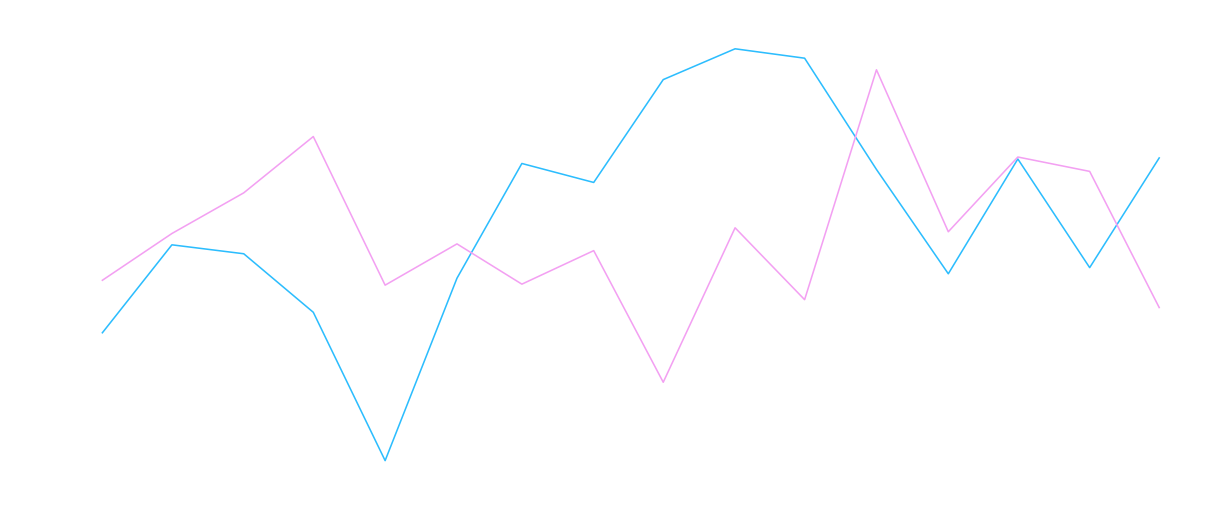

{'Air Wisconsin Airlines Corp':             LOAD_FACTOR      PRED
DATE                             
2018-09-01     0.769966  0.774876
2018-10-01     0.806268  0.813643
2018-11-01     0.799055  0.824140
2018-12-01     0.793741  0.802061
2019-01-01     0.735209  0.747367
2019-02-01     0.733679  0.760886
2019-03-01     0.798623  0.777255
2019-04-01     0.816824  0.767923
2019-05-01     0.828379  0.827312
2019-06-01     0.847843  0.783519
2019-07-01     0.846853  0.773625
2019-08-01     0.819580  0.784470
2019-09-01     0.783461  0.784295
2019-10-01     0.822442  0.771708
2019-11-01     0.781773  0.745434
2019-12-01     0.816928  0.771671, 'Alaska Airlines Inc.':             LOAD_FACTOR      PRED
DATE                             
2018-09-01     0.811888  0.852953
2018-10-01     0.841316  0.848957
2018-11-01     0.844520  0.847571
2018-12-01     0.825926  0.826961
2019-01-01     0.768883  0.849023
2019-02-01     0.790976  0.860266
2019-03-01     0.843745  0.862841
2019-04-01     0.849986  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


METRIC TEMPORAIRE :0.019571673153173784


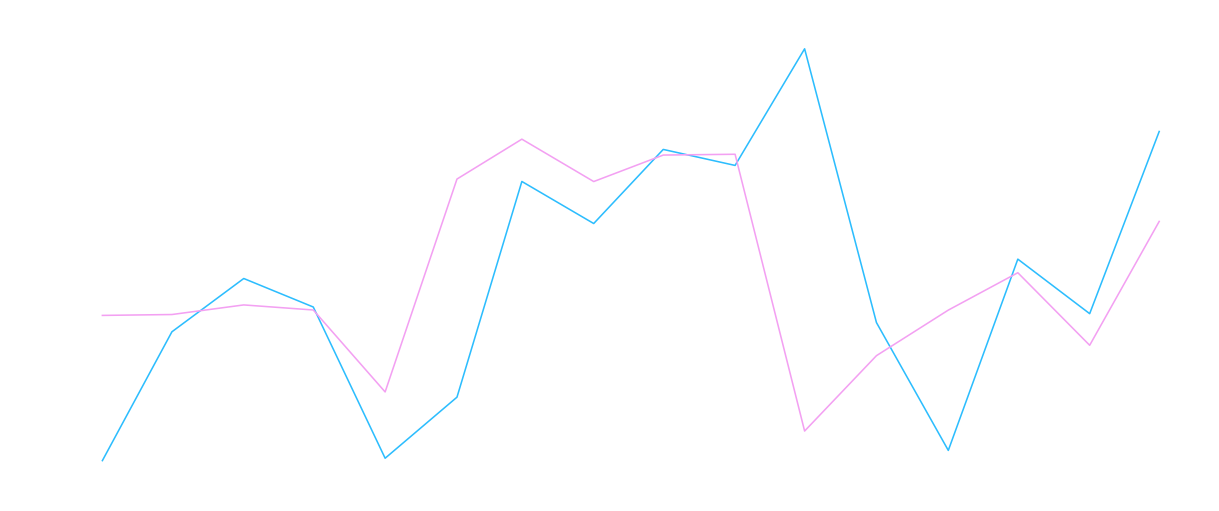

{'Air Wisconsin Airlines Corp':             LOAD_FACTOR      PRED
DATE                             
2018-09-01     0.769966  0.774876
2018-10-01     0.806268  0.813643
2018-11-01     0.799055  0.824140
2018-12-01     0.793741  0.802061
2019-01-01     0.735209  0.747367
2019-02-01     0.733679  0.760886
2019-03-01     0.798623  0.777255
2019-04-01     0.816824  0.767923
2019-05-01     0.828379  0.827312
2019-06-01     0.847843  0.783519
2019-07-01     0.846853  0.773625
2019-08-01     0.819580  0.784470
2019-09-01     0.783461  0.784295
2019-10-01     0.822442  0.771708
2019-11-01     0.781773  0.745434
2019-12-01     0.816928  0.771671, 'Alaska Airlines Inc.':             LOAD_FACTOR      PRED
DATE                             
2018-09-01     0.811888  0.852953
2018-10-01     0.841316  0.848957
2018-11-01     0.844520  0.847571
2018-12-01     0.825926  0.826961
2019-01-01     0.768883  0.849023
2019-02-01     0.790976  0.860266
2019-03-01     0.843745  0.862841
2019-04-01     0.849986  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


METRIC TEMPORAIRE :0.026239017436375543


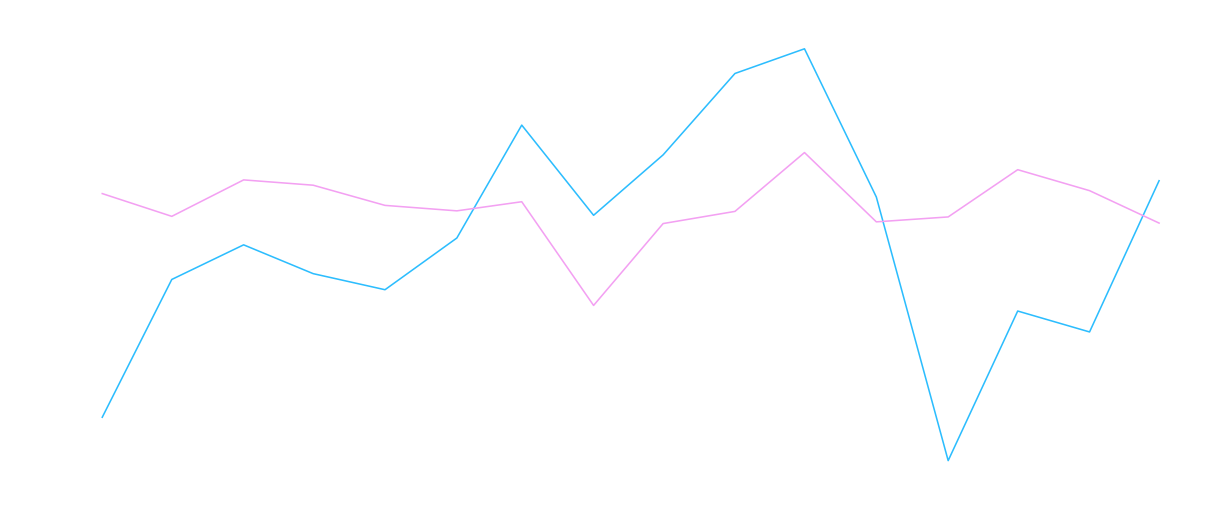

{'Air Wisconsin Airlines Corp':             LOAD_FACTOR      PRED
DATE                             
2018-09-01     0.769966  0.774876
2018-10-01     0.806268  0.813643
2018-11-01     0.799055  0.824140
2018-12-01     0.793741  0.802061
2019-01-01     0.735209  0.747367
2019-02-01     0.733679  0.760886
2019-03-01     0.798623  0.777255
2019-04-01     0.816824  0.767923
2019-05-01     0.828379  0.827312
2019-06-01     0.847843  0.783519
2019-07-01     0.846853  0.773625
2019-08-01     0.819580  0.784470
2019-09-01     0.783461  0.784295
2019-10-01     0.822442  0.771708
2019-11-01     0.781773  0.745434
2019-12-01     0.816928  0.771671, 'Alaska Airlines Inc.':             LOAD_FACTOR      PRED
DATE                             
2018-09-01     0.811888  0.852953
2018-10-01     0.841316  0.848957
2018-11-01     0.844520  0.847571
2018-12-01     0.825926  0.826961
2019-01-01     0.768883  0.849023
2019-02-01     0.790976  0.860266
2019-03-01     0.843745  0.862841
2019-04-01     0.849986  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


METRIC TEMPORAIRE :0.02724133894966016


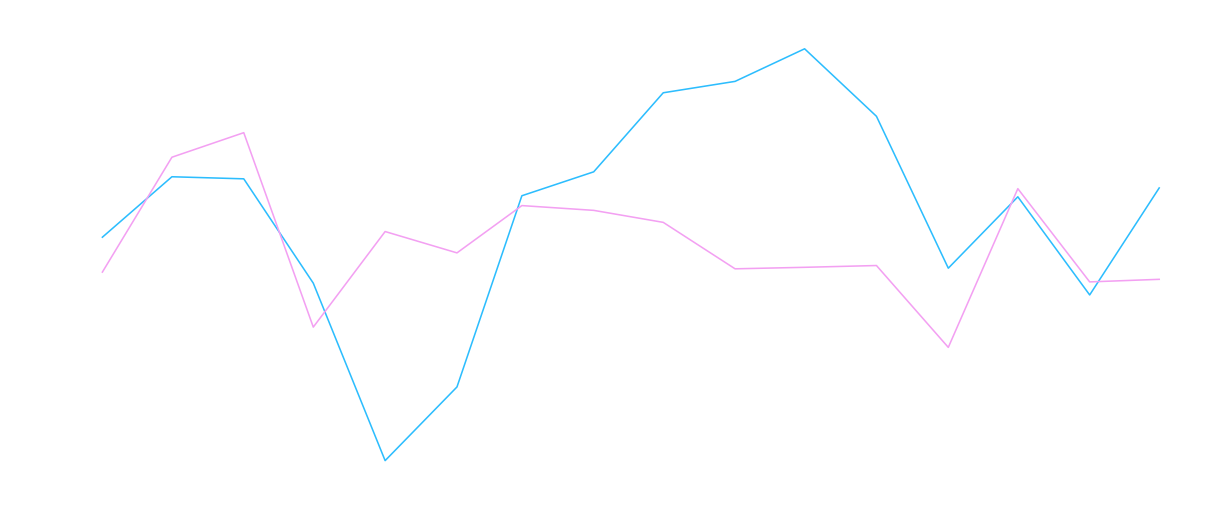

{'Air Wisconsin Airlines Corp':             LOAD_FACTOR      PRED
DATE                             
2018-09-01     0.769966  0.774876
2018-10-01     0.806268  0.813643
2018-11-01     0.799055  0.824140
2018-12-01     0.793741  0.802061
2019-01-01     0.735209  0.747367
2019-02-01     0.733679  0.760886
2019-03-01     0.798623  0.777255
2019-04-01     0.816824  0.767923
2019-05-01     0.828379  0.827312
2019-06-01     0.847843  0.783519
2019-07-01     0.846853  0.773625
2019-08-01     0.819580  0.784470
2019-09-01     0.783461  0.784295
2019-10-01     0.822442  0.771708
2019-11-01     0.781773  0.745434
2019-12-01     0.816928  0.771671, 'Alaska Airlines Inc.':             LOAD_FACTOR      PRED
DATE                             
2018-09-01     0.811888  0.852953
2018-10-01     0.841316  0.848957
2018-11-01     0.844520  0.847571
2018-12-01     0.825926  0.826961
2019-01-01     0.768883  0.849023
2019-02-01     0.790976  0.860266
2019-03-01     0.843745  0.862841
2019-04-01     0.849986  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


METRIC TEMPORAIRE :0.039849112516332275


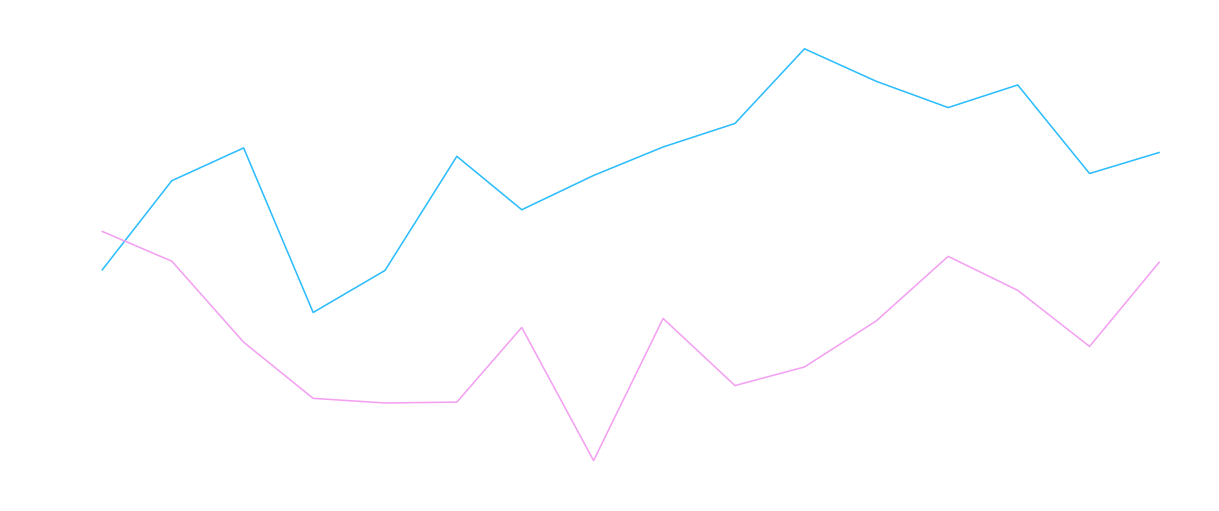

{'Air Wisconsin Airlines Corp':             LOAD_FACTOR      PRED
DATE                             
2018-09-01     0.769966  0.774876
2018-10-01     0.806268  0.813643
2018-11-01     0.799055  0.824140
2018-12-01     0.793741  0.802061
2019-01-01     0.735209  0.747367
2019-02-01     0.733679  0.760886
2019-03-01     0.798623  0.777255
2019-04-01     0.816824  0.767923
2019-05-01     0.828379  0.827312
2019-06-01     0.847843  0.783519
2019-07-01     0.846853  0.773625
2019-08-01     0.819580  0.784470
2019-09-01     0.783461  0.784295
2019-10-01     0.822442  0.771708
2019-11-01     0.781773  0.745434
2019-12-01     0.816928  0.771671, 'Alaska Airlines Inc.':             LOAD_FACTOR      PRED
DATE                             
2018-09-01     0.811888  0.852953
2018-10-01     0.841316  0.848957
2018-11-01     0.844520  0.847571
2018-12-01     0.825926  0.826961
2019-01-01     0.768883  0.849023
2019-02-01     0.790976  0.860266
2019-03-01     0.843745  0.862841
2019-04-01     0.849986  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


METRIC TEMPORAIRE :0.02844990581347106


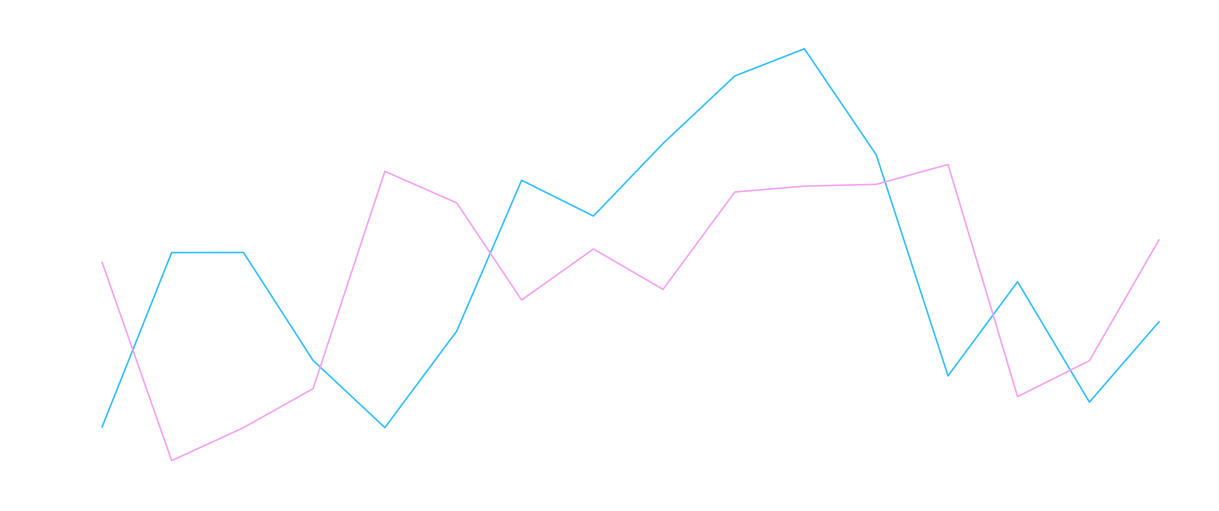

{'Air Wisconsin Airlines Corp':             LOAD_FACTOR      PRED
DATE                             
2018-09-01     0.769966  0.774876
2018-10-01     0.806268  0.813643
2018-11-01     0.799055  0.824140
2018-12-01     0.793741  0.802061
2019-01-01     0.735209  0.747367
2019-02-01     0.733679  0.760886
2019-03-01     0.798623  0.777255
2019-04-01     0.816824  0.767923
2019-05-01     0.828379  0.827312
2019-06-01     0.847843  0.783519
2019-07-01     0.846853  0.773625
2019-08-01     0.819580  0.784470
2019-09-01     0.783461  0.784295
2019-10-01     0.822442  0.771708
2019-11-01     0.781773  0.745434
2019-12-01     0.816928  0.771671, 'Alaska Airlines Inc.':             LOAD_FACTOR      PRED
DATE                             
2018-09-01     0.811888  0.852953
2018-10-01     0.841316  0.848957
2018-11-01     0.844520  0.847571
2018-12-01     0.825926  0.826961
2019-01-01     0.768883  0.849023
2019-02-01     0.790976  0.860266
2019-03-01     0.843745  0.862841
2019-04-01     0.849986  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


METRIC TEMPORAIRE :0.026907636007948876


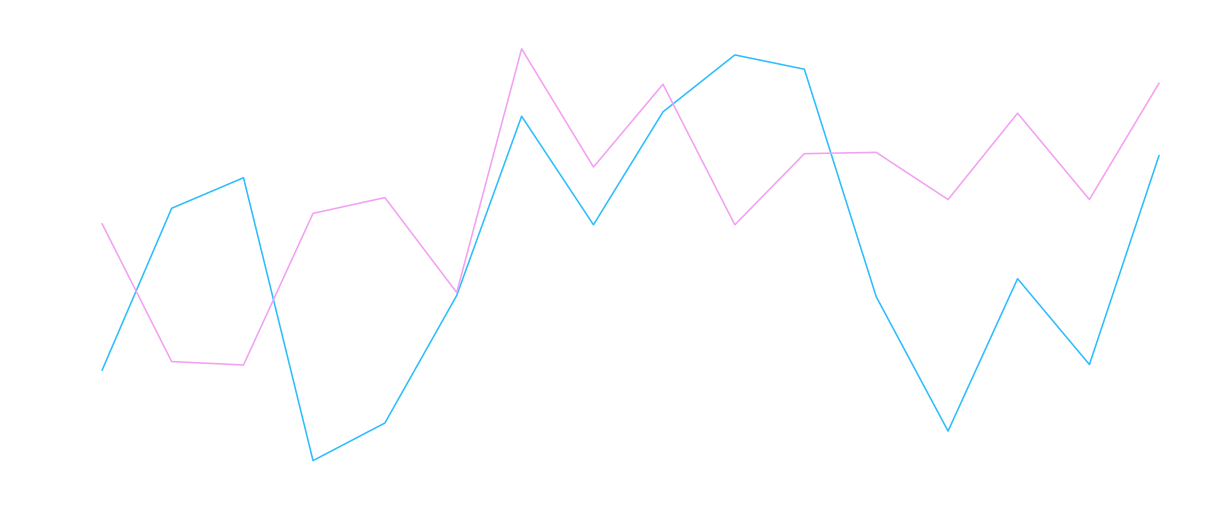

{'Air Wisconsin Airlines Corp':             LOAD_FACTOR      PRED
DATE                             
2018-09-01     0.769966  0.774876
2018-10-01     0.806268  0.813643
2018-11-01     0.799055  0.824140
2018-12-01     0.793741  0.802061
2019-01-01     0.735209  0.747367
2019-02-01     0.733679  0.760886
2019-03-01     0.798623  0.777255
2019-04-01     0.816824  0.767923
2019-05-01     0.828379  0.827312
2019-06-01     0.847843  0.783519
2019-07-01     0.846853  0.773625
2019-08-01     0.819580  0.784470
2019-09-01     0.783461  0.784295
2019-10-01     0.822442  0.771708
2019-11-01     0.781773  0.745434
2019-12-01     0.816928  0.771671, 'Alaska Airlines Inc.':             LOAD_FACTOR      PRED
DATE                             
2018-09-01     0.811888  0.852953
2018-10-01     0.841316  0.848957
2018-11-01     0.844520  0.847571
2018-12-01     0.825926  0.826961
2019-01-01     0.768883  0.849023
2019-02-01     0.790976  0.860266
2019-03-01     0.843745  0.862841
2019-04-01     0.849986  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


METRIC TEMPORAIRE :0.028575301641695368


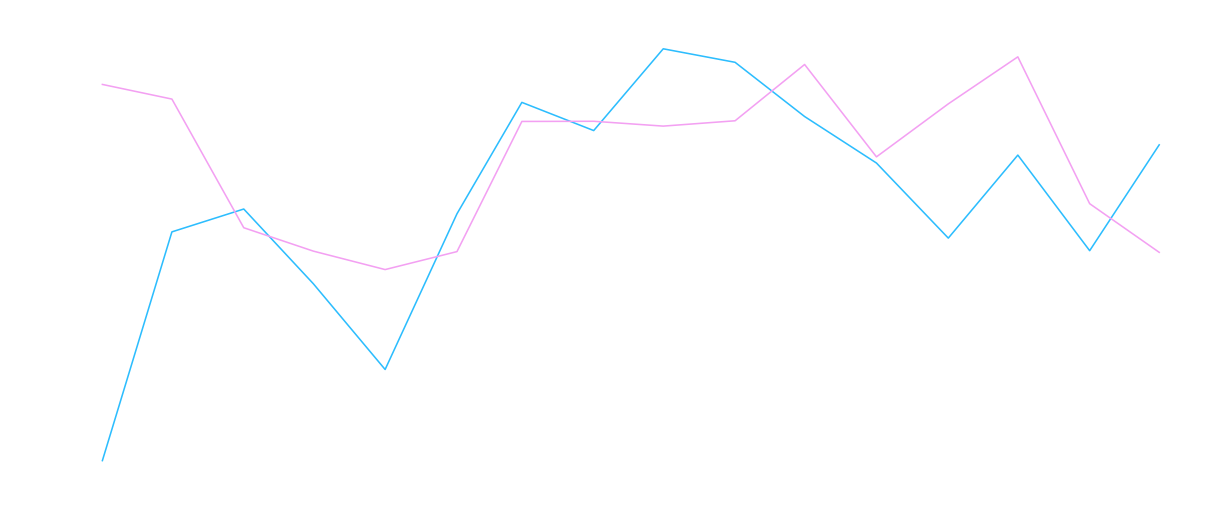

{'Air Wisconsin Airlines Corp':             LOAD_FACTOR      PRED
DATE                             
2018-09-01     0.769966  0.774876
2018-10-01     0.806268  0.813643
2018-11-01     0.799055  0.824140
2018-12-01     0.793741  0.802061
2019-01-01     0.735209  0.747367
2019-02-01     0.733679  0.760886
2019-03-01     0.798623  0.777255
2019-04-01     0.816824  0.767923
2019-05-01     0.828379  0.827312
2019-06-01     0.847843  0.783519
2019-07-01     0.846853  0.773625
2019-08-01     0.819580  0.784470
2019-09-01     0.783461  0.784295
2019-10-01     0.822442  0.771708
2019-11-01     0.781773  0.745434
2019-12-01     0.816928  0.771671, 'Alaska Airlines Inc.':             LOAD_FACTOR      PRED
DATE                             
2018-09-01     0.811888  0.852953
2018-10-01     0.841316  0.848957
2018-11-01     0.844520  0.847571
2018-12-01     0.825926  0.826961
2019-01-01     0.768883  0.849023
2019-02-01     0.790976  0.860266
2019-03-01     0.843745  0.862841
2019-04-01     0.849986  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


METRIC TEMPORAIRE :0.06177449240962056


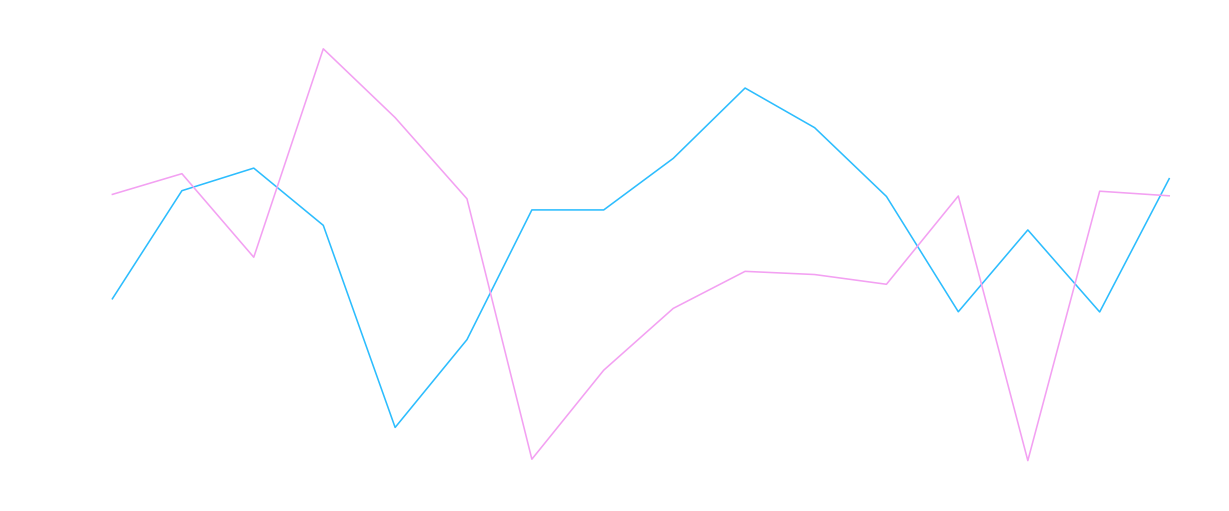

{'Air Wisconsin Airlines Corp':             LOAD_FACTOR      PRED
DATE                             
2018-09-01     0.769966  0.774876
2018-10-01     0.806268  0.813643
2018-11-01     0.799055  0.824140
2018-12-01     0.793741  0.802061
2019-01-01     0.735209  0.747367
2019-02-01     0.733679  0.760886
2019-03-01     0.798623  0.777255
2019-04-01     0.816824  0.767923
2019-05-01     0.828379  0.827312
2019-06-01     0.847843  0.783519
2019-07-01     0.846853  0.773625
2019-08-01     0.819580  0.784470
2019-09-01     0.783461  0.784295
2019-10-01     0.822442  0.771708
2019-11-01     0.781773  0.745434
2019-12-01     0.816928  0.771671, 'Alaska Airlines Inc.':             LOAD_FACTOR      PRED
DATE                             
2018-09-01     0.811888  0.852953
2018-10-01     0.841316  0.848957
2018-11-01     0.844520  0.847571
2018-12-01     0.825926  0.826961
2019-01-01     0.768883  0.849023
2019-02-01     0.790976  0.860266
2019-03-01     0.843745  0.862841
2019-04-01     0.849986  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


METRIC TEMPORAIRE :0.08859859068397043


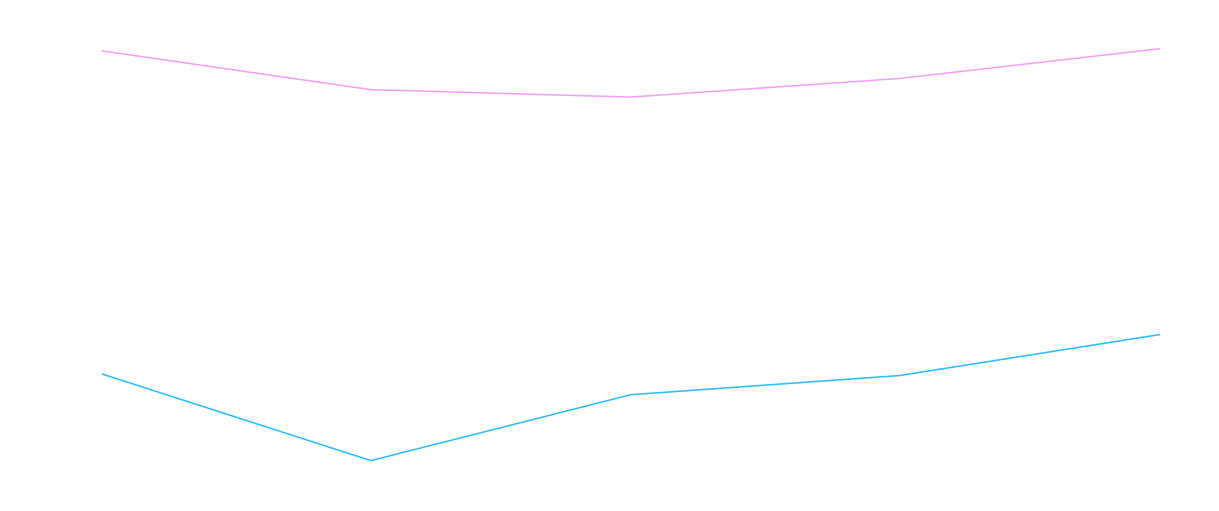

{'Air Wisconsin Airlines Corp':             LOAD_FACTOR      PRED
DATE                             
2018-09-01     0.769966  0.774876
2018-10-01     0.806268  0.813643
2018-11-01     0.799055  0.824140
2018-12-01     0.793741  0.802061
2019-01-01     0.735209  0.747367
2019-02-01     0.733679  0.760886
2019-03-01     0.798623  0.777255
2019-04-01     0.816824  0.767923
2019-05-01     0.828379  0.827312
2019-06-01     0.847843  0.783519
2019-07-01     0.846853  0.773625
2019-08-01     0.819580  0.784470
2019-09-01     0.783461  0.784295
2019-10-01     0.822442  0.771708
2019-11-01     0.781773  0.745434
2019-12-01     0.816928  0.771671, 'Alaska Airlines Inc.':             LOAD_FACTOR      PRED
DATE                             
2018-09-01     0.811888  0.852953
2018-10-01     0.841316  0.848957
2018-11-01     0.844520  0.847571
2018-12-01     0.825926  0.826961
2019-01-01     0.768883  0.849023
2019-02-01     0.790976  0.860266
2019-03-01     0.843745  0.862841
2019-04-01     0.849986  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


METRIC TEMPORAIRE :0.023514641323708965


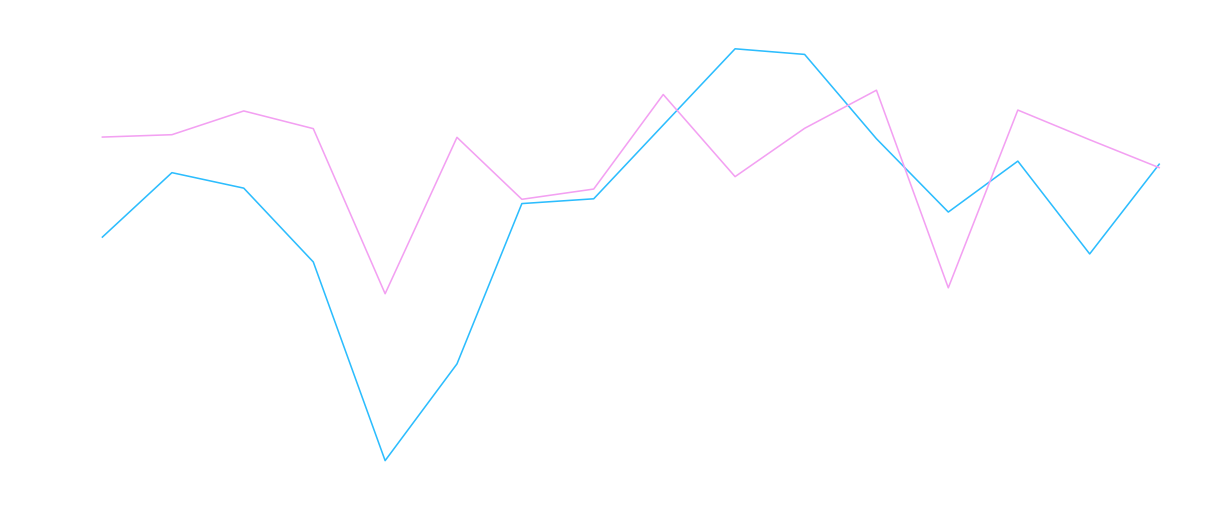

{'Air Wisconsin Airlines Corp':             LOAD_FACTOR      PRED
DATE                             
2018-09-01     0.769966  0.774876
2018-10-01     0.806268  0.813643
2018-11-01     0.799055  0.824140
2018-12-01     0.793741  0.802061
2019-01-01     0.735209  0.747367
2019-02-01     0.733679  0.760886
2019-03-01     0.798623  0.777255
2019-04-01     0.816824  0.767923
2019-05-01     0.828379  0.827312
2019-06-01     0.847843  0.783519
2019-07-01     0.846853  0.773625
2019-08-01     0.819580  0.784470
2019-09-01     0.783461  0.784295
2019-10-01     0.822442  0.771708
2019-11-01     0.781773  0.745434
2019-12-01     0.816928  0.771671, 'Alaska Airlines Inc.':             LOAD_FACTOR      PRED
DATE                             
2018-09-01     0.811888  0.852953
2018-10-01     0.841316  0.848957
2018-11-01     0.844520  0.847571
2018-12-01     0.825926  0.826961
2019-01-01     0.768883  0.849023
2019-02-01     0.790976  0.860266
2019-03-01     0.843745  0.862841
2019-04-01     0.849986  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


METRIC TEMPORAIRE :0.03665223318378373


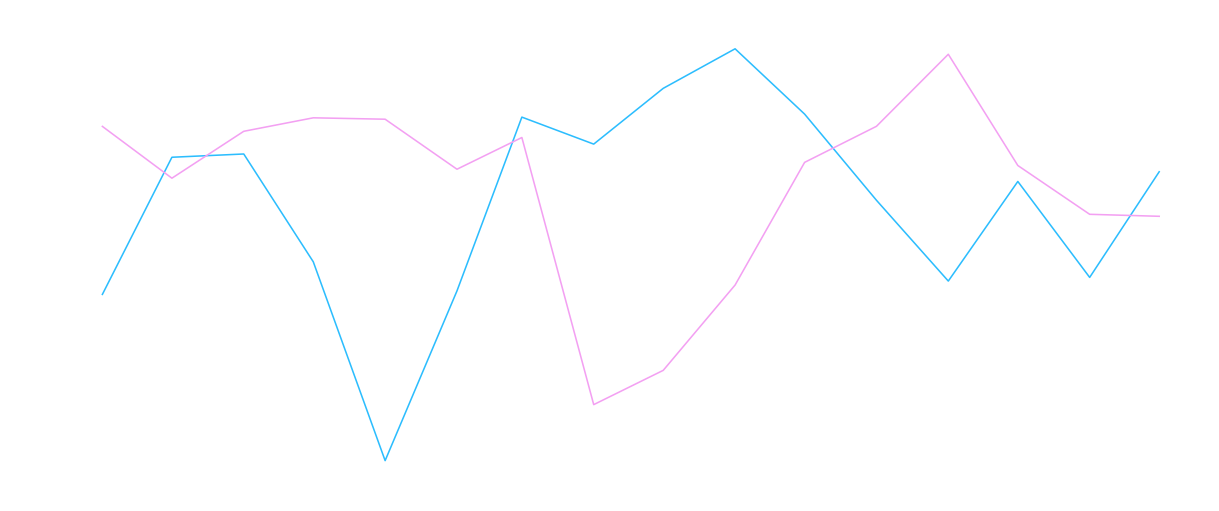

{'Air Wisconsin Airlines Corp':             LOAD_FACTOR      PRED
DATE                             
2018-09-01     0.769966  0.774876
2018-10-01     0.806268  0.813643
2018-11-01     0.799055  0.824140
2018-12-01     0.793741  0.802061
2019-01-01     0.735209  0.747367
2019-02-01     0.733679  0.760886
2019-03-01     0.798623  0.777255
2019-04-01     0.816824  0.767923
2019-05-01     0.828379  0.827312
2019-06-01     0.847843  0.783519
2019-07-01     0.846853  0.773625
2019-08-01     0.819580  0.784470
2019-09-01     0.783461  0.784295
2019-10-01     0.822442  0.771708
2019-11-01     0.781773  0.745434
2019-12-01     0.816928  0.771671, 'Alaska Airlines Inc.':             LOAD_FACTOR      PRED
DATE                             
2018-09-01     0.811888  0.852953
2018-10-01     0.841316  0.848957
2018-11-01     0.844520  0.847571
2018-12-01     0.825926  0.826961
2019-01-01     0.768883  0.849023
2019-02-01     0.790976  0.860266
2019-03-01     0.843745  0.862841
2019-04-01     0.849986  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


METRIC TEMPORAIRE :0.022938208093591934


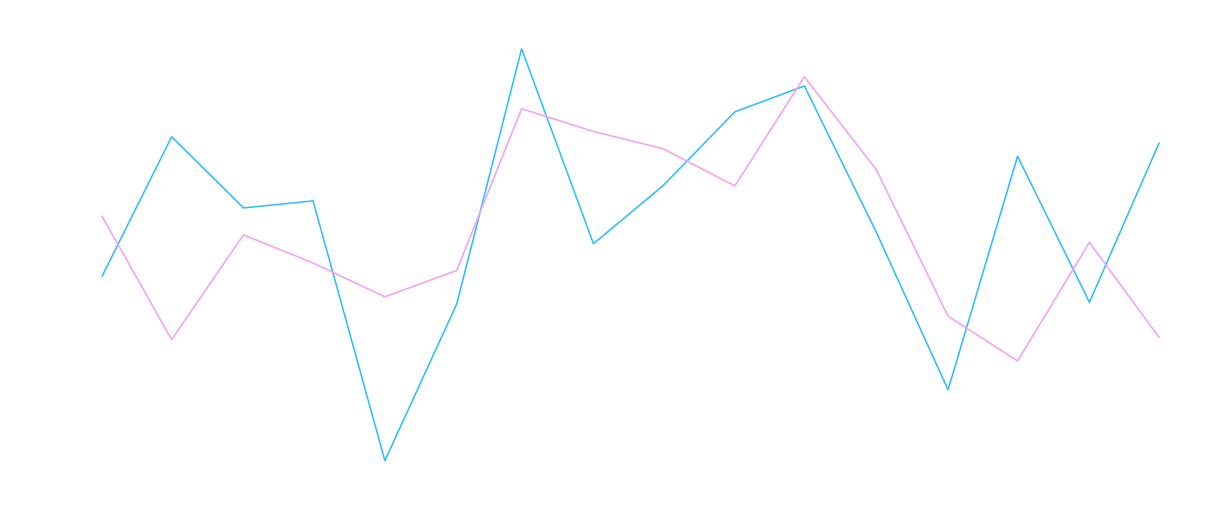

{'Air Wisconsin Airlines Corp':             LOAD_FACTOR      PRED
DATE                             
2018-09-01     0.769966  0.774876
2018-10-01     0.806268  0.813643
2018-11-01     0.799055  0.824140
2018-12-01     0.793741  0.802061
2019-01-01     0.735209  0.747367
2019-02-01     0.733679  0.760886
2019-03-01     0.798623  0.777255
2019-04-01     0.816824  0.767923
2019-05-01     0.828379  0.827312
2019-06-01     0.847843  0.783519
2019-07-01     0.846853  0.773625
2019-08-01     0.819580  0.784470
2019-09-01     0.783461  0.784295
2019-10-01     0.822442  0.771708
2019-11-01     0.781773  0.745434
2019-12-01     0.816928  0.771671, 'Alaska Airlines Inc.':             LOAD_FACTOR      PRED
DATE                             
2018-09-01     0.811888  0.852953
2018-10-01     0.841316  0.848957
2018-11-01     0.844520  0.847571
2018-12-01     0.825926  0.826961
2019-01-01     0.768883  0.849023
2019-02-01     0.790976  0.860266
2019-03-01     0.843745  0.862841
2019-04-01     0.849986  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


METRIC TEMPORAIRE :0.04614831026555851


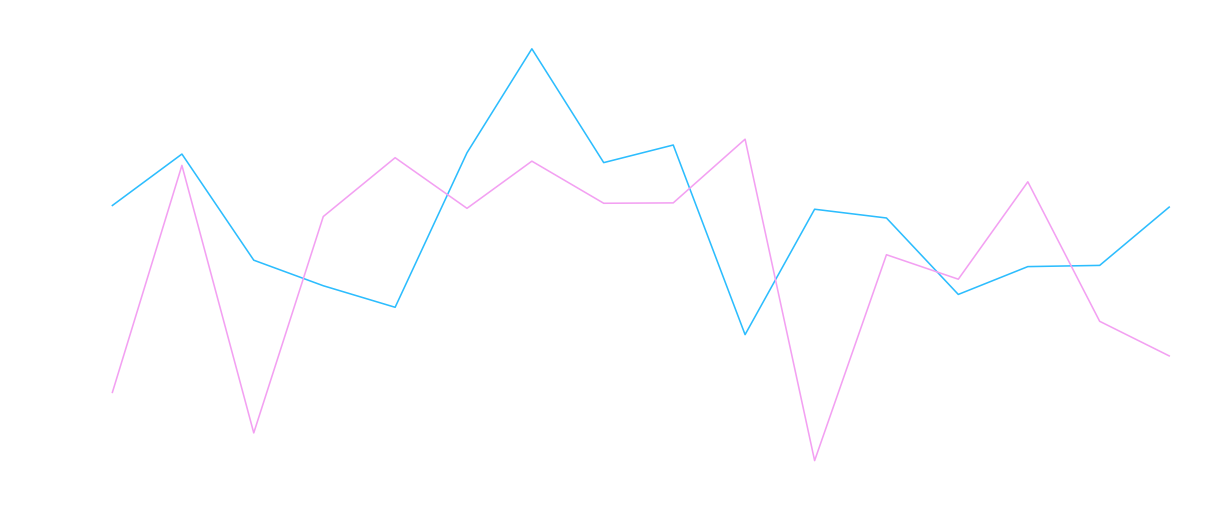

{'Air Wisconsin Airlines Corp':             LOAD_FACTOR      PRED
DATE                             
2018-09-01     0.769966  0.774876
2018-10-01     0.806268  0.813643
2018-11-01     0.799055  0.824140
2018-12-01     0.793741  0.802061
2019-01-01     0.735209  0.747367
2019-02-01     0.733679  0.760886
2019-03-01     0.798623  0.777255
2019-04-01     0.816824  0.767923
2019-05-01     0.828379  0.827312
2019-06-01     0.847843  0.783519
2019-07-01     0.846853  0.773625
2019-08-01     0.819580  0.784470
2019-09-01     0.783461  0.784295
2019-10-01     0.822442  0.771708
2019-11-01     0.781773  0.745434
2019-12-01     0.816928  0.771671, 'Alaska Airlines Inc.':             LOAD_FACTOR      PRED
DATE                             
2018-09-01     0.811888  0.852953
2018-10-01     0.841316  0.848957
2018-11-01     0.844520  0.847571
2018-12-01     0.825926  0.826961
2019-01-01     0.768883  0.849023
2019-02-01     0.790976  0.860266
2019-03-01     0.843745  0.862841
2019-04-01     0.849986  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


METRIC TEMPORAIRE :0.03128785683067945


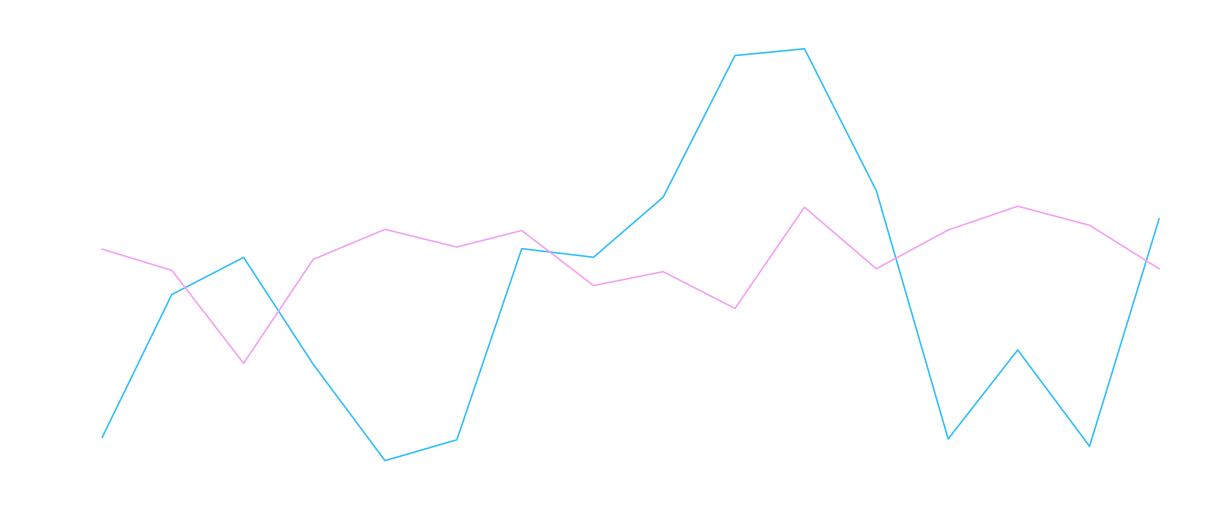

{'Air Wisconsin Airlines Corp':             LOAD_FACTOR      PRED
DATE                             
2018-09-01     0.769966  0.774876
2018-10-01     0.806268  0.813643
2018-11-01     0.799055  0.824140
2018-12-01     0.793741  0.802061
2019-01-01     0.735209  0.747367
2019-02-01     0.733679  0.760886
2019-03-01     0.798623  0.777255
2019-04-01     0.816824  0.767923
2019-05-01     0.828379  0.827312
2019-06-01     0.847843  0.783519
2019-07-01     0.846853  0.773625
2019-08-01     0.819580  0.784470
2019-09-01     0.783461  0.784295
2019-10-01     0.822442  0.771708
2019-11-01     0.781773  0.745434
2019-12-01     0.816928  0.771671, 'Alaska Airlines Inc.':             LOAD_FACTOR      PRED
DATE                             
2018-09-01     0.811888  0.852953
2018-10-01     0.841316  0.848957
2018-11-01     0.844520  0.847571
2018-12-01     0.825926  0.826961
2019-01-01     0.768883  0.849023
2019-02-01     0.790976  0.860266
2019-03-01     0.843745  0.862841
2019-04-01     0.849986  

In [115]:
predictions = LSTM_forecast(dataframe_collection, win_length, batch_size, num_features, model2)

In [7]:
data_scaled = df_carrier.to_numpy()

In [8]:
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df_carrier)

In [137]:
final_pred = pd.concat(predictions)
final_pred.head()

LOAD_FACTOR      PRED
                            DATE                             
Air Wisconsin Airlines Corp 2018-09-01     0.769966  0.774876
                            2018-10-01     0.806268  0.813643
                            2018-11-01     0.799055  0.824140
                            2018-12-01     0.793741  0.802061
                            2019-01-01     0.735209  0.747367

In [138]:
final_pred.reset_index(level=0, inplace=True)
final_pred.rename(columns={'level_0': 'UNIQUE_CARRIER_NAME'}, inplace = True)
final_pred.reset_index(level=0, inplace=True)
final_pred.rename(columns={'level_0': 'DATE'}, inplace = True)

In [141]:
final_pred.head()

,DATE,UNIQUE_CARRIER_NAME,LOAD_FACTOR,PRED
0,2018-09-01,Air Wisconsin Airlines Corp,0.769966,0.774876
1,2018-10-01,Air Wisconsin Airlines Corp,0.806268,0.813643
2,2018-11-01,Air Wisconsin Airlines Corp,0.799055,0.824140
3,2018-12-01,Air Wisconsin Airlines Corp,0.793741,0.802061
4,2019-01-01,Air Wisconsin Airlines Corp,0.735209,0.747367


In [142]:
mean_absolute_error(final_pred['LOAD_FACTOR'], final_pred['PRED'])

0.031277123380438594